In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import TomekLinks
from sklearn.utils.class_weight import compute_class_weight 
import os
import pandas as pd
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [5]:
os.chdir("D:/Data_Science_ML_IITR_Sem_3")
df = pd.read_csv("celebral stroke prediction imbalance dataset.csv")
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,5450,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,28375,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,27973,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


In [6]:
df.shape

(43400, 12)

In [7]:
stroke_counts = df['stroke'].value_counts()
stroke_counts

stroke
0    42617
1      783
Name: count, dtype: int64

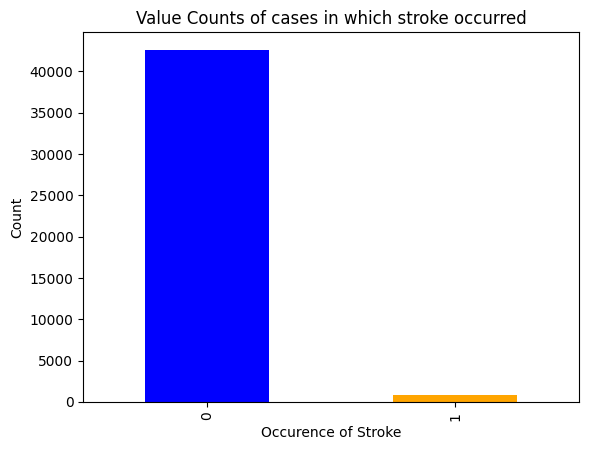

In [8]:
stroke_counts.plot(kind='bar', color =['blue', 'orange'])
plt.title('Value Counts of cases in which stroke occurred')
plt.xlabel('Occurence of Stroke')
plt.ylabel('Count')

plt.show()

In [9]:
# Create a copy of the dataframe to avoid altering the original
df_label_encoded = df.copy()

# List of categorical columns to label encode
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Apply LabelEncoder to each categorical column
label_encoder = LabelEncoder()

for column in categorical_columns:
    df_label_encoded[column] = label_encoder.fit_transform(df_label_encoded[column].astype(str))

# gender: male = 1, female =0
#ever married: yes = 1, no = 0
#work type: 0 = gpvernment job, 1 = never worked, 2 = private, 3 = self employed, 4 = children
# residence type: 0 = rural, 1 = urban
# smoking_status: 0 = formerly smoked, 1 = NaN, 2 = never smoked, 3 = smokes

#deleting the rows in which smoking_status = 1, becuase 1 represented NaN Values
df_label_encoded = df_label_encoded[df_label_encoded['smoking_status'] != 1]

# Check the first few rows of the label encoded dataframe
df_label_encoded.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,30468,1,58.0,1,0,1,2,1,87.96,39.2,2,0
3,56543,0,70.0,0,0,1,2,0,69.04,35.9,0,0
6,52800,0,52.0,0,0,1,2,1,77.59,17.7,0,0
7,41413,0,75.0,0,1,1,3,0,243.53,27.0,2,0
8,15266,0,32.0,0,0,1,2,0,77.67,32.3,3,0


In [10]:
df_label_encoded.isnull().sum()

id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                  1036
smoking_status          0
stroke                  0
dtype: int64

In [12]:
# Filling missing values in the 'bmi' column with the mean of the 'bmi' column
df_label_encoded['bmi'].fillna(df_label_encoded['bmi'].mean(), inplace=True)

# Checking if null values have been filled successfully
df_label_encoded.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,30468,1,58.0,1,0,1,2,1,87.96,39.2,2,0
3,56543,0,70.0,0,0,1,2,0,69.04,35.9,0,0
6,52800,0,52.0,0,0,1,2,1,77.59,17.7,0,0
7,41413,0,75.0,0,1,1,3,0,243.53,27.0,2,0
8,15266,0,32.0,0,0,1,2,0,77.67,32.3,3,0


In [21]:
df_label_encoded.drop('id', axis = 1, inplace = True)

In [22]:
df_label_encoded.tail()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
43395,0,10.0,0,0,0,4,1,58.64,20.4,2,0
43396,0,56.0,0,0,1,0,1,213.61,55.4,0,0
43397,0,82.0,1,0,1,2,1,91.94,28.9,0,0
43398,1,40.0,0,0,1,2,1,99.16,33.2,2,0
43399,0,82.0,0,0,1,2,1,79.48,20.6,2,0


In [23]:
df_label_encoded.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [26]:
# Split the dataset into features and target variable
X = df_label_encoded.drop('stroke', axis=1)
y = df_label_encoded['stroke']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [27]:
# Random Under Sampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train) 

In [28]:
# Random Over Sampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [29]:
# SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [30]:
# Tomek Links
tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X_train, y_train) 

In [31]:
# Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights)) 

### Training with Random Forest Classifier

In [56]:
# Function to evaluate model performance
def evaluate_model(X_train, y_train, X_test, y_test, class_weights=None):
    # hyperparameters defining grid
    param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}
    model = RandomForestClassifier(class_weight=class_weights, random_state=35)

    # Use RandomizedSearchCV to search for the best hyperparameters
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                       n_iter=10, scoring='roc_auc', cv=3, verbose=1,
                                       random_state=35, n_jobs=-1)
    # Fit RandomizedSearchCV to the training data
    random_search.fit(X_train, y_train)

     # Retrieve the best model
    model = random_search.best_estimator_
    print("Best Hyperparameters:", random_search.best_params_)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(classification_report(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_prob))

In [57]:
# Evaluate each sampling technique
print("Random Undersampling:")
evaluate_model(X_rus, y_rus, X_test, y_test)

print("\nRandom Oversampling:")
evaluate_model(X_ros, y_ros, X_test, y_test)

print("\nSMOTE:")
evaluate_model(X_smote, y_smote, X_test, y_test)

print("\nTomek Links:")
evaluate_model(X_tl, y_tl, X_test, y_test)

print("\nClass Weights:")
evaluate_model(X_train, y_train, X_test, y_test, class_weights_dict) 

Random Undersampling:
              precision    recall  f1-score   support

           0       0.99      0.72      0.84      5890
           1       0.06      0.77      0.11       132

    accuracy                           0.72      6022
   macro avg       0.53      0.74      0.47      6022
weighted avg       0.97      0.72      0.82      6022

AUC: 0.8145791531614962

Random Oversampling:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5890
           1       0.00      0.00      0.00       132

    accuracy                           0.98      6022
   macro avg       0.49      0.50      0.49      6022
weighted avg       0.96      0.98      0.97      6022

AUC: 0.7755903688840871

SMOTE:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5890
           1       0.06      0.09      0.07       132

    accuracy                           0.95      6022
   macro avg       0.52     

### Random Undersampling proved to be most effective as it gave the most Area Under Curve (AUC)

In [58]:
# checking proportion of stroke = yes (1)
y_rus[y_rus==1].count()/y_rus.count()  ## y_rus is the 'stroke' column (target variable)

0.5

In [59]:
# checking proportion of stroke = no (0)
y_rus[y_rus==0].count()/y_rus.count()

0.5